In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
import pandas as pd
import joblib
import sys
sys.path.append('../lib')
from utils import edf_loader, combiner, annotations_reader, find_breakpoints, find_sections,\
                    section_seiz, find_edf
from transformers import SpectrogramTransformer
from models import Baseline, PostProcessing
import time

In [5]:
files1 = find_edf('../dataset/edf/train/01_tcp_ar/')
files2 = find_edf('../dataset/edf/train/02_tcp_le/')
files3 = find_edf('../dataset/edf/train/03_tcp_ar_a/')
files = [files1, files2, files3]

In [6]:
len(files1), len(files2), len(files3)

(3177, 486, 934)

In [7]:
len(files3), len(np.unique(files3))

(934, 934)

In [8]:
len(files1), len(files2), len(files3)

(3177, 486, 934)

In [9]:
len(files3), len(np.unique(files3))

(934, 934)

# Test Baseline class

In [14]:
id_file = 0
file = files1[id_file]
raw = edf_loader(file)
raw.info['montage_type'] = 1
tmax = raw.n_times/raw.info['sfreq']
wd = 8
S = SpectrogramTransformer(win_duration=wd)
t, f, spectrograms_db_list = S.fit_transform(raw)

In [15]:
from matplotlib import pyplot as plt

In [16]:
S.t.shape, S.f.shape, len(spectrograms_db_list), spectrograms_db_list[0].shape

((14,), (801,), 22, (801, 14))

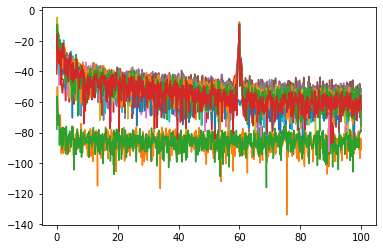

In [17]:
plt.plot(S.f, spectrograms_db_list[0])

# Launch pipeline for every folder

In [18]:
def write_predictions(f, basename, predictions, deltaT, wd, tmax):
    seiz_start_list = [seiz_start for seiz_start in range(1,len(predictions)-1)
                                  if not predictions[seiz_start-1] and predictions[seiz_start]]
    seiz_end_list = [find_seiz_end(predictions, seiz_start) for seiz_start in seiz_start_list]
    for seiz_start, seiz_end in zip(seiz_start_list, seiz_end_list):
        t_start = deltaT + seiz_start*wd
        t_end = min(tmax, deltaT + seiz_end*wd)
        f.write('{}\t{}\t{}\t{}\n'.format(basename, t_start, t_end, confidency_level))

In [19]:
%%time
N = 100
wd = 8
confidency_level = 0.9
S = SpectrogramTransformer(win_duration=wd)
B = Baseline(wd)
P = PostProcessing()
with open('../eval/v3.3.1/test_with_PP/hyp.txt', 'w') as f:
    for montage_type, files_list in enumerate(files, 1):
        # for i, file in enumerate(files_list[:N]):
        for i, file in enumerate(files_list):
            print(i, file)
#             basename = os.path.splitext(os.path.basename(file))[0]
            raw = edf_loader(file)
            raw.info['montage_type'] = montage_type
            tmax = raw.n_times/raw.info['sfreq']
            # t,f,spectrograms_db_list = S.fit_transform(raw)
            B.fit(*S.fit_transform(raw))
            P.fit(*B.predict())
            predictions = P.predict()
            # write_predictions(f, basename, predictions, deltaT, wd, tmax)

0 ../dataset/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/00004456_s012_t002.edf
1 ../dataset/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/00004456_s012_t003.edf


KeyboardInterrupt: 